In [94]:
import kagglehub
import shutil
import os

# Step 1: Download dataset (downloads to ~/.kagglehub)
dataset_path = kagglehub.dataset_download('hugomathien/soccer')

# Step 2: Define your flat target folder (e.g., 'data')
target_path = 'data'

# Step 3: Copy all files (flat) into the target folder
if not os.path.exists(target_path):
    os.makedirs(target_path)

for filename in os.listdir(dataset_path):
    src_file = os.path.join(dataset_path, filename)
    dst_file = os.path.join(target_path, filename)

    if os.path.isfile(src_file):  # ignore folders
        shutil.copy2(src_file, dst_file)

print(f"All dataset files copied to: {target_path}")


All dataset files copied to: data


In [95]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter("ignore")

In [96]:
inputs = pd.read_parquet("data/inputs.parquet")

#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)

#Splitting the data into Train, Calibrate, and Test data sets
X_meta_train, X_meta_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42,
                                                                        stratify = labels)
X_train = X_meta_train.drop(columns=['moon_phase_num', 'weather_code', 'rain_sum'])
X_test = X_meta_test.drop(columns=['moon_phase_num', 'weather_code', 'rain_sum'])

In [97]:
## Initializing all models and parameters
#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB_clf = GaussianNB()
KNN_clf =  KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "saga", class_weight = 'balanced', random_state = 189)
clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'],
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5),
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_GNB = {'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_KNN = {'clf__n_neighbors': [3, 5, 10],
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5),
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int


parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_GNB,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG}

#Initializing dimensionality reductions
pca = PCA()
dm_reductions = [pca]

## Train a Logistic Regression Model as Primary Model

In [98]:
from sklearn.model_selection import GridSearchCV

## Training a baseline model and finding the best model composition using grid search
#Train a simple GBC classifier as baseline model
clf = LOG_clf
clf.fit(X_train, y_train)

# Define a grid of hyperparameters for Logistic Regression
param_grid = {
    'C': [100],
    'solver': ['saga'],
    'class_weight': [None],
    'multi_class': ['ovr']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=189, max_iter=100),
    param_grid=param_grid,
    scoring='precision',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Use the best estimator found
clf = grid_search.best_estimator_
print("Best Logistic Regression parameters:", grid_search.best_params_)


y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, y_pred_train)))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, y_pred_test)))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Logistic Regression parameters: {'C': 100, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'saga'}
Score of LogisticRegression for training set: 0.5241.
Score of LogisticRegression for test set: 0.5300.


In [99]:

##### Blog for Meta Labeling

# Store meta labels (1 if correct, 0 if incorrect)
meta_labels_train = (y_pred_train == y_train).astype(int)
meta_labels_test = (y_pred_test == y_test).astype(int)

# get Meta Features
meta_features_train = clf.predict_proba(X_train)
meta_features_test = clf.predict_proba(X_test)
#######

In [100]:
# Step 6: Wettstrategie auswerten für Primary Model
df_bets = X_test.copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = y_pred_test
df_bets["actual_outcome"] = y_test

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain_Primary = df_bets["money"].sum()
avg_gain_Primary = df_bets["money"].mean()
num_bets_Primary = len(df_bets)

# Anzahl korrekte Wetten
correct_Primary = (df_bets["predicted_outcome"] == df_bets["actual_outcome"]).sum()
total_Primary = num_bets_Primary
percentage_correct_Primary = correct_Primary / total_Primary if total_Primary > 0 else 0

# Sharpe Ratio berechnen
returns = df_bets["money"].values
mean_return = np.mean(returns) if len(returns) > 0 else 0
std_return = np.std(returns, ddof=1) if len(returns) > 1 else 0
sharpe_ratio_Primary = mean_return / std_return if std_return > 0 else np.nan
sharpe_annualized_Primary = sharpe_ratio_Primary * np.sqrt(num_bets_Primary) if not np.isnan(sharpe_ratio_Primary) else np.nan

print(f"\n💰 Gesamtgewinn: {total_gain_Primary:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain_Primary:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets_Primary}")
print(f"✅ Anzahl korrekte Wetten: {correct_Primary}/{total_Primary} ({percentage_correct_Primary:.4f})")
print(f"⚖️  Sharpe Ratio: {sharpe_ratio_Primary:.3f}")
print(f"📆 Annualized Sharpe Ratio: {sharpe_annualized_Primary:.3f}")



💰 Gesamtgewinn: -145.19 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.041 EUR
🎲 Anzahl getätigter Wetten: 3528
✅ Anzahl korrekte Wetten: 1870/3528 (0.5300)
⚖️  Sharpe Ratio: -0.043
📆 Annualized Sharpe Ratio: -2.526


### SHAP Primary Model

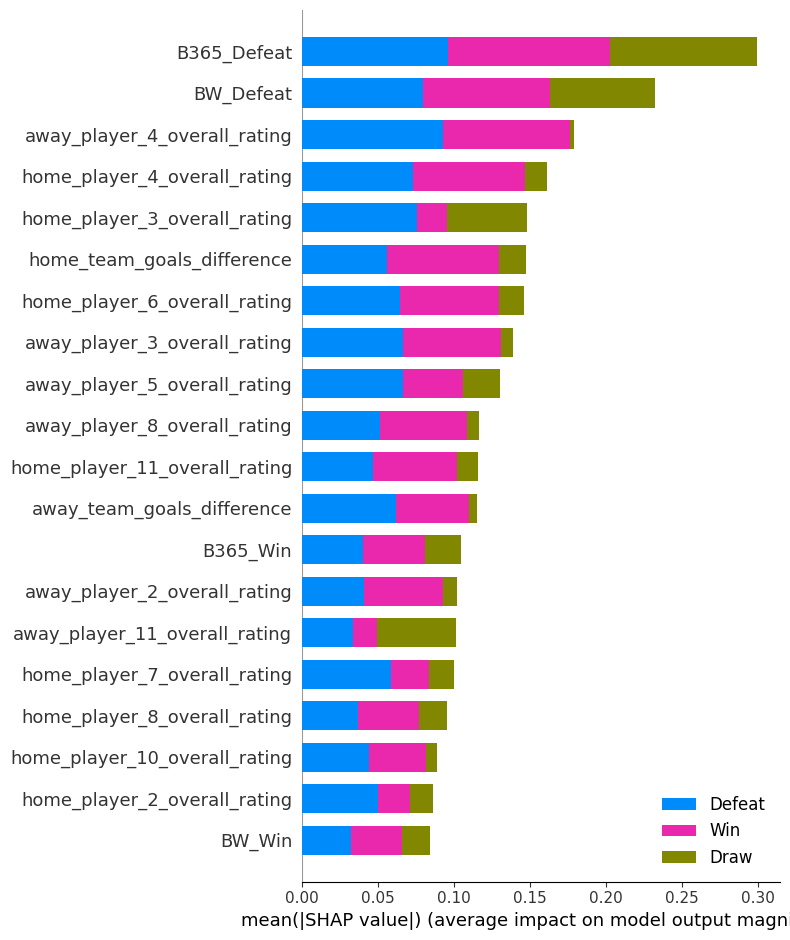

In [101]:
import shap

explainer = shap.Explainer(clf, X_train.astype(float))

shap_values = explainer(X_test.astype(float))

shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=['Defeat', 'Draw', 'Win'])



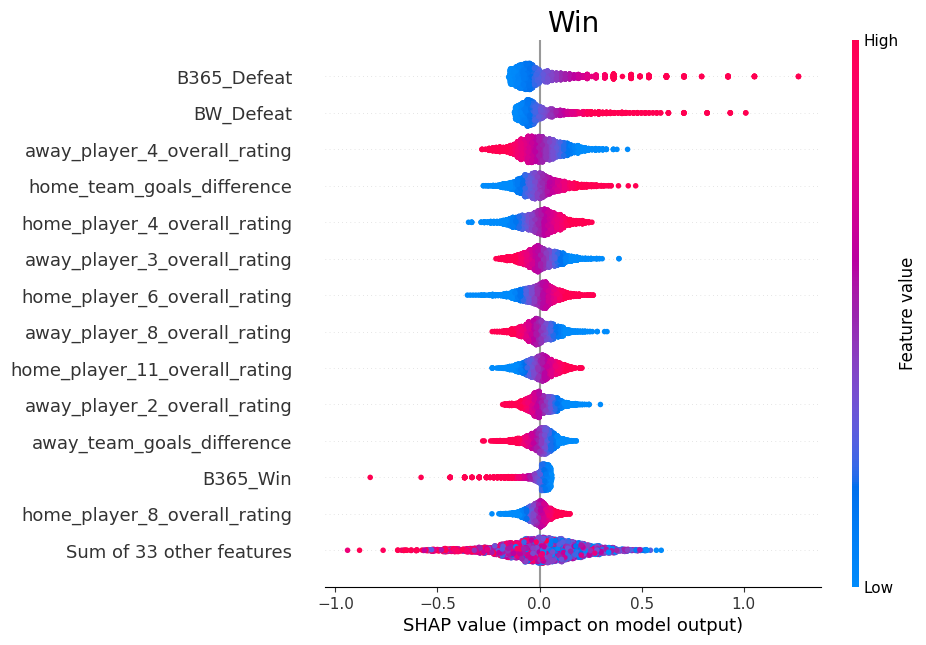

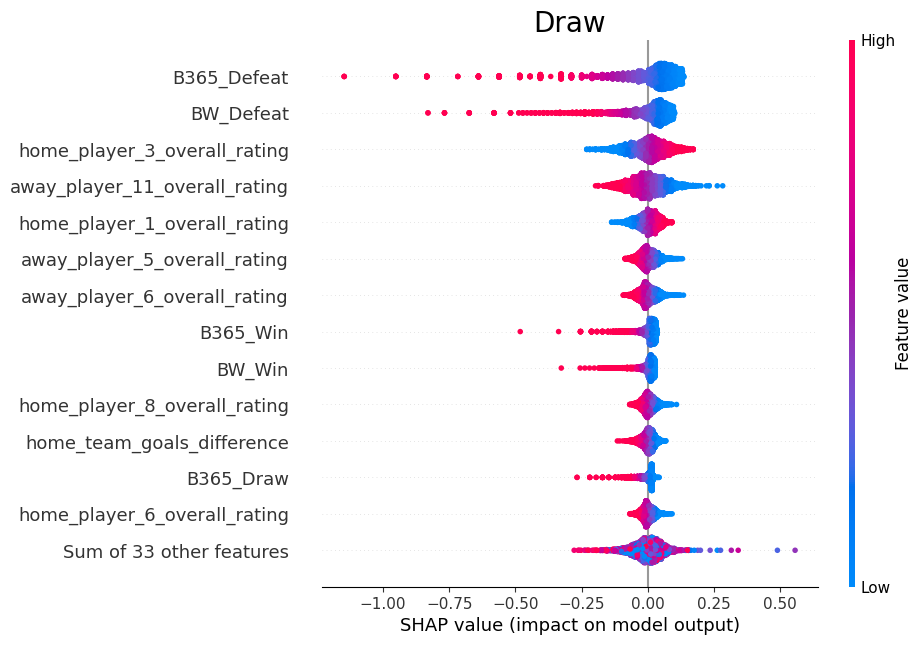

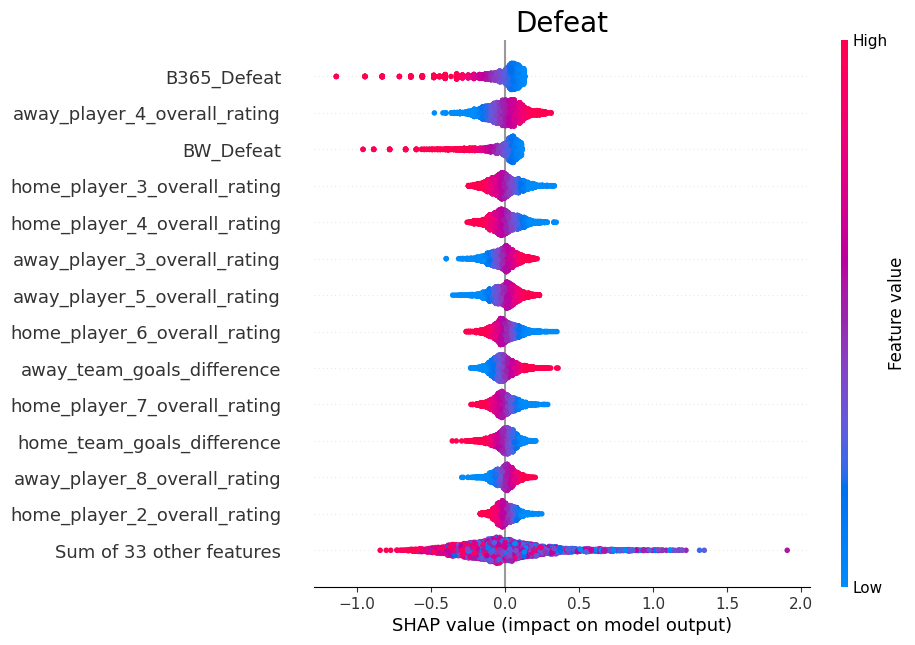

In [102]:


shap.plots.beeswarm(shap_values[:,:,2], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Win", fontsize=20)
plt.show()
shap.plots.beeswarm(shap_values[:,:,1], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Draw", fontsize=20)
plt.show()
shap.plots.beeswarm(shap_values[:,:,0], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Defeat", fontsize=20)
plt.show()



# Meta Labeling

In [103]:
meta_features_df = pd.DataFrame(meta_features_train, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_meta_train = pd.concat([X_meta_train.reset_index(drop=True), meta_features_df], axis=1)
y_meta_train = meta_labels_train
meta_features_test_df = pd.DataFrame(meta_features_test, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_meta_test = pd.concat([X_meta_test.reset_index(drop=True), meta_features_test_df], axis=1)
y_meta_test = meta_labels_test

## Find best params for Logistic Regression Model as Secondary Model

In [104]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
'''
meta_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               # Stärke der Regularisierung (klein = stark reguliert)
    'class_weight': [None, 'balanced'],         # Gewichtung der Klassen
    'penalty': ['l1', 'l2']                     # L1 = Lasso, L2 = Ridge Regularisierung
}

# Best meta-model parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
# Best cross-validation precision: 0.6810314323249272

# GridSearchCV
meta_grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42, solver="saga"),
    param_grid=meta_param_grid,
    scoring='precision',   
    cv=2,                
    n_jobs=-1,
    verbose=1
)

# Fit
meta_grid_search.fit(X_meta_train, y_meta_train)

# Ergebnisse
meta_clf_Logistic = meta_grid_search.best_estimator_
print("Best meta-model parameters:", meta_grid_search.best_params_)
print("Best cross-validation precision:", meta_grid_search.best_score_)
'''


'\nmeta_param_grid = {\n    \'C\': [0.01, 0.1, 1, 10, 100],               # Stärke der Regularisierung (klein = stark reguliert)\n    \'class_weight\': [None, \'balanced\'],         # Gewichtung der Klassen\n    \'penalty\': [\'l1\', \'l2\']                     # L1 = Lasso, L2 = Ridge Regularisierung\n}\n\n# Best meta-model parameters: {\'C\': 0.01, \'class_weight\': \'balanced\', \'penalty\': \'l1\'}\n# Best cross-validation precision: 0.6810314323249272\n\n# GridSearchCV\nmeta_grid_search = GridSearchCV(\n    estimator=LogisticRegression(max_iter=1000, random_state=42, solver="saga"),\n    param_grid=meta_param_grid,\n    scoring=\'precision\',   \n    cv=2,                \n    n_jobs=-1,\n    verbose=1\n)\n\n# Fit\nmeta_grid_search.fit(X_meta_train, y_meta_train)\n\n# Ergebnisse\nmeta_clf_Logistic = meta_grid_search.best_estimator_\nprint("Best meta-model parameters:", meta_grid_search.best_params_)\nprint("Best cross-validation precision:", meta_grid_search.best_score_)\n'

## Train Logistic Regression Model as Secondary Model

In [105]:
# Best hyperparameters from search
meta_clf_Logistic = LogisticRegression(
    C=0.01,
    class_weight='balanced',
    penalty='l1',
    solver='saga',         # required for L1
    max_iter=1000,
    random_state=42
)

# Step 5: Train the meta-model
meta_clf_Logistic.fit(X_meta_train, y_meta_train)


# Evaluate
y_meta_pred = meta_clf_Logistic.predict(X_meta_test)
print("Meta model accuracy on predicting if primary model is correct:", accuracy_score(y_meta_test, y_meta_pred))

# Step 4: Finale Vorhersage – nur wenn Meta-Modell "vertraut"
final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)

# Find indices where final_prediction is not 0
nonzero_indices = np.where(final_prediction != 0)[0]

# Get the corresponding predictions and true labels
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

# Calculate accuracy for these predictions
correct_LR = (preds == true_labels).sum()
total_LR = len(nonzero_indices)
percentage_correct_LR = correct_LR / total_LR if total_LR > 0 else 0
print(f"Correct predicts on bets: {percentage_correct_LR:.4f} ({correct_LR}/{total_LR})")

# Step 6: Wettstrategie auswerten
df_bets =  X_meta_test.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1
    else:
        return -1

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain_LR = df_bets["money"].sum()
avg_gain_LR = df_bets["money"].mean()
num_bets_LR = len(df_bets)

# Sharpe Ratio berechnen
returns = df_bets["money"].values
mean_return = np.mean(returns) if len(returns) > 0 else 0
std_return = np.std(returns, ddof=1) if len(returns) > 1 else 0
sharpe_ratio_LR = mean_return / std_return if std_return > 0 else np.nan
sharpe_annualized_LR = sharpe_ratio_LR * np.sqrt(num_bets_LR) if not np.isnan(sharpe_ratio_LR) else np.nan

print(f"\n💰 Gesamtgewinn: {total_gain_LR:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain_LR:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets_LR}")
print(f"⚖️  Sharpe Ratio: {sharpe_ratio_LR:.3f}")
print(f"📆 Annualized Sharpe Ratio: {sharpe_annualized_LR:.3f}")


Meta model accuracy on predicting if primary model is correct: 0.6009070294784581
Correct predicts on bets: 0.6981 (814/1166)

💰 Gesamtgewinn: -31.85 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.027 EUR
🎲 Anzahl getätigter Wetten: 1166
⚖️  Sharpe Ratio: -0.041
📆 Annualized Sharpe Ratio: -1.415


### SHAP LR

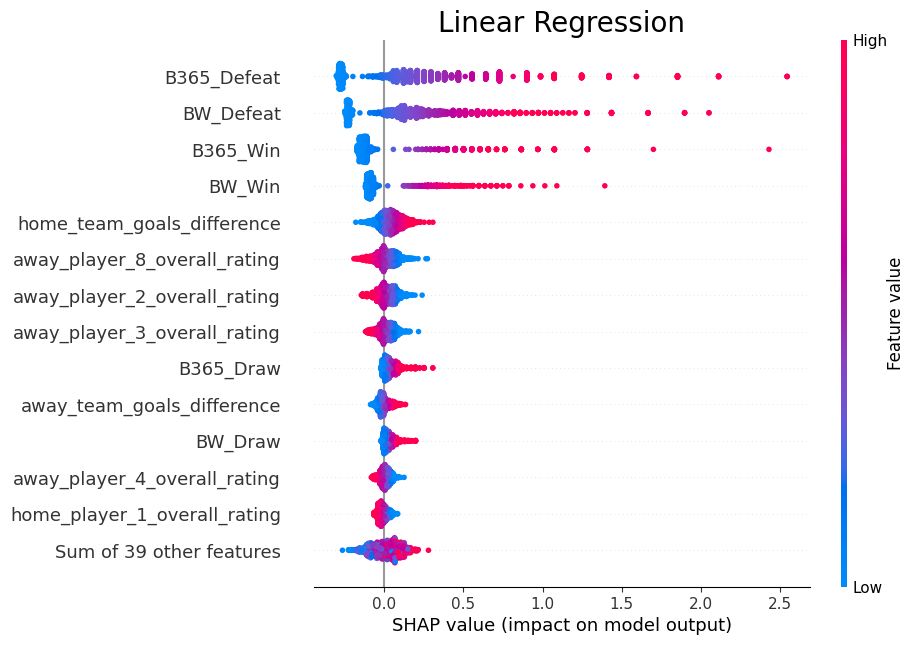

In [106]:


explainer = shap.Explainer(meta_clf_Logistic, X_meta_train.astype(float))
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.beeswarm(shap_values, max_display=14, show=False)
ax = plt.gca()
ax.set_title("Linear Regression", fontsize=20)
plt.show()



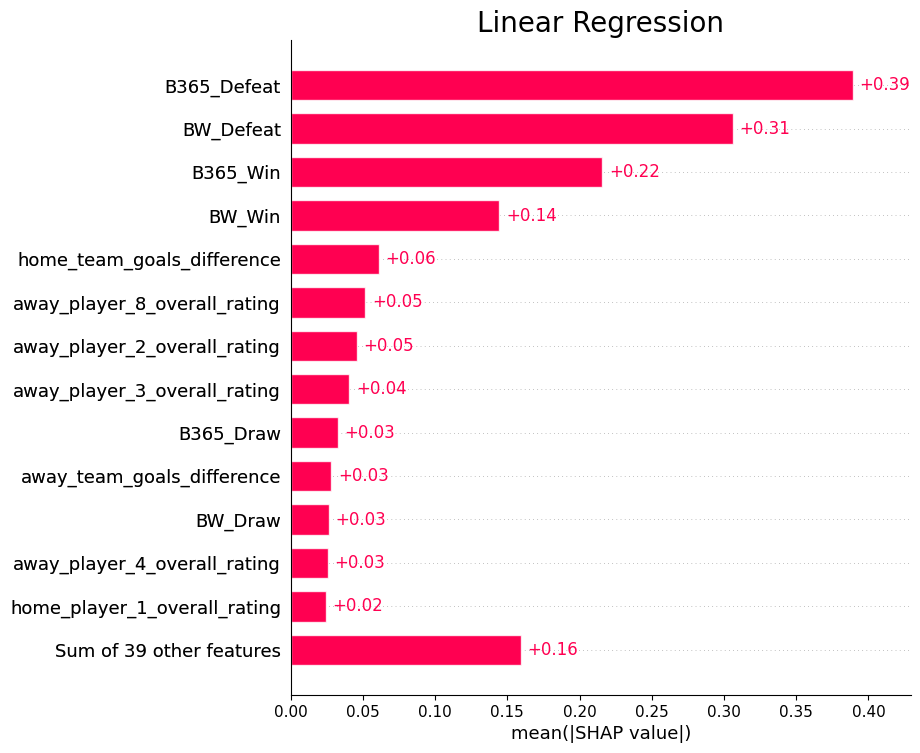

In [107]:


explainer = shap.Explainer(meta_clf_Logistic, X_meta_train.astype(float))
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.bar(shap_values, max_display=14, show=False)
ax = plt.gca()
ax.set_title("Linear Regression", fontsize=20)
plt.show()


## Find best params for LGBM Classifier as Secondary Model

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint, uniform as sp_uniform
import pandas as pd

'''
# --- Hyperparameter Distributions ---
param_dist = {
    'n_estimators': sp_randint(100, 1000),         # Anzahl Bäume
    'learning_rate': sp_uniform(0.01, 0.3),       # Lernrate
    'num_leaves': sp_randint(15, 255),            # Blätter pro Baum
    'max_depth': sp_randint(3, 15),               # Maximale Tiefe
    'min_child_samples': sp_randint(5, 100),      # Min. Daten pro Blatt
    'subsample': sp_uniform(0.5, 0.5),            # Zeilen-Sampling (0.5–1.0)
    'colsample_bytree': sp_uniform(0.5, 0.5),     # Feature-Sampling (0.5–1.0)
    'reg_alpha': sp_uniform(0.0, 1.0),            # L1 Regularisierung
    'reg_lambda': sp_uniform(0.0, 1.0),           # L2 Regularisierung
}

# --- Basismodell ---
lgbm = LGBMClassifier(
    objective='binary',
    device='gpu',
    random_state=42,
    n_jobs=1,
    verbose=-1
)

# --- Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=10,          # Anzahl der zufälligen Kombinationen
    cv=3,               # Cross Validation
    scoring='precision', # oder 'f1', 'roc_auc'
    verbose=10,
    random_state=42,
    n_jobs=1
)

# Best hyperparameters found: {'colsample_bytree': np.float64(0.7252496259847715), 'device': 'gpu', 'learning_rate': np.float64(0.013979488347959958), 'max_depth': 11, 'min_child_samples': 64, 'n_estimators': 113, 'num_leaves': 23, 'reg_alpha': np.float64(0.015966252220214194), 'reg_lambda': np.float64(0.230893825622149), 'subsample': np.float64(0.6205127330130058)}
# Best cross-validation precision: 0.6357203798061165

print("Performing hyperparameter search for LGBMClassifier...")
random_search.fit(X_meta_train, y_meta_train)

meta_clf_LGBM = random_search.best_estimator_

print("\nBest hyperparameters found:", random_search.best_params_)
print("Best cross-validation precision:", random_search.best_score_)

'''

'\n# --- Hyperparameter Distributions ---\nparam_dist = {\n    \'n_estimators\': sp_randint(100, 1000),         # Anzahl Bäume\n    \'learning_rate\': sp_uniform(0.01, 0.3),       # Lernrate\n    \'num_leaves\': sp_randint(15, 255),            # Blätter pro Baum\n    \'max_depth\': sp_randint(3, 15),               # Maximale Tiefe\n    \'min_child_samples\': sp_randint(5, 100),      # Min. Daten pro Blatt\n    \'subsample\': sp_uniform(0.5, 0.5),            # Zeilen-Sampling (0.5–1.0)\n    \'colsample_bytree\': sp_uniform(0.5, 0.5),     # Feature-Sampling (0.5–1.0)\n    \'reg_alpha\': sp_uniform(0.0, 1.0),            # L1 Regularisierung\n    \'reg_lambda\': sp_uniform(0.0, 1.0),           # L2 Regularisierung\n}\n\n# --- Basismodell ---\nlgbm = LGBMClassifier(\n    objective=\'binary\',\n    device=\'gpu\',\n    random_state=42,\n    n_jobs=1,\n    verbose=-1\n)\n\n# --- Randomized Search ---\nrandom_search = RandomizedSearchCV(\n    estimator=lgbm,\n    param_distributions=param_dist

## Train LGBM Model as Secondary Model

In [109]:
# Best hyperparameters from search
meta_clf_LGBM = LGBMClassifier(
    colsample_bytree=0.7252496259847715,
    device='cpu',                         # GPU training if possible
    learning_rate=0.013979488347959958,
    max_depth=11,
    min_child_samples=64,
    n_estimators=113,
    num_leaves=23,
    reg_alpha=0.015966252220214194,
    reg_lambda=0.230893825622149,
    subsample=0.6205127330130058,
    random_state=42
)


# Step 1: Meta-Modell trainieren
meta_clf_LGBM.fit(X_meta_train, y_meta_train)


# Step 3: Meta-Vorhersagen treffen
y_meta_pred = meta_clf_LGBM.predict(X_meta_test)
print("Meta model accuracy on predicting if primary model is correct:",
      accuracy_score(y_meta_test, y_meta_pred))

# Step 4: Finale Vorhersage – nur wenn Meta-Modell "vertraut"
final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)  # 0 = keine Wette

# Step 5: Trefferquote unter Meta-genehmigten Tipps
nonzero_indices = np.where(final_prediction != 0)[0]
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

correct_LGBM = (preds == true_labels).sum()
total_LGBM = len(nonzero_indices)
percentage_correct_LGBM = correct_LGBM / total_LGBM if total_LGBM > 0 else 0
print(f"Correct predicts on bets: {percentage_correct_LGBM:.4f} ({correct_LGBM}/{total_LGBM})")

# Step 6: Wettstrategie auswerten
df_bets = X_meta_test.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain_LGBM = df_bets["money"].sum()
avg_gain_LGBM = df_bets["money"].mean()
num_bets_LGBM = len(df_bets)

# Sharpe Ratio berechnen
returns = df_bets["money"].values
mean_return = np.mean(returns) if len(returns) > 0 else 0
std_return = np.std(returns, ddof=1) if len(returns) > 1 else 0
sharpe_ratio_LGBM = mean_return / std_return if std_return > 0 else np.nan
sharpe_annualized_LGBM = sharpe_ratio_LGBM * np.sqrt(num_bets_LGBM) if not np.isnan(sharpe_ratio_LGBM) else np.nan

print(f"\n💰 Gesamtgewinn: {total_gain_LGBM:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain_LGBM:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets_LGBM}")
print(f"⚖️  Sharpe Ratio: {sharpe_ratio_LGBM:.3f}")
print(f"📆 Annualized Sharpe Ratio: {sharpe_annualized_LGBM:.3f}")


[LightGBM] [Info] Number of positive: 7396, number of negative: 6716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3261
[LightGBM] [Info] Number of data points in the train set: 14112, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524093 -> initscore=0.096447
[LightGBM] [Info] Start training from score 0.096447
Meta model accuracy on predicting if primary model is correct: 0.6201814058956916
Correct predicts on bets: 0.6583 (1102/1674)

💰 Gesamtgewinn: -19.77 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.012 EUR
🎲 Anzahl getätigter Wetten: 1674
⚖️  Sharpe Ratio: -0.016
📆 Annualized Sharpe Ratio: -0.651


### SHAP LGBM

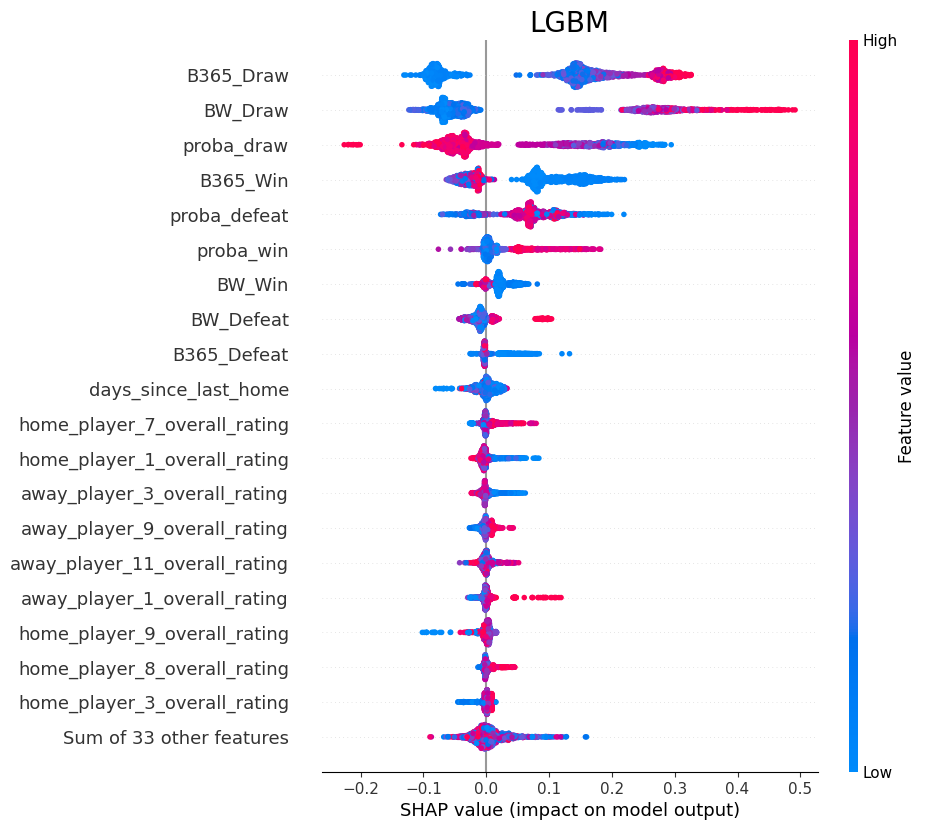

In [110]:
explainer = shap.Explainer(meta_clf_LGBM)
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
ax = plt.gca()
ax.set_title("LGBM", fontsize=20)
plt.show()

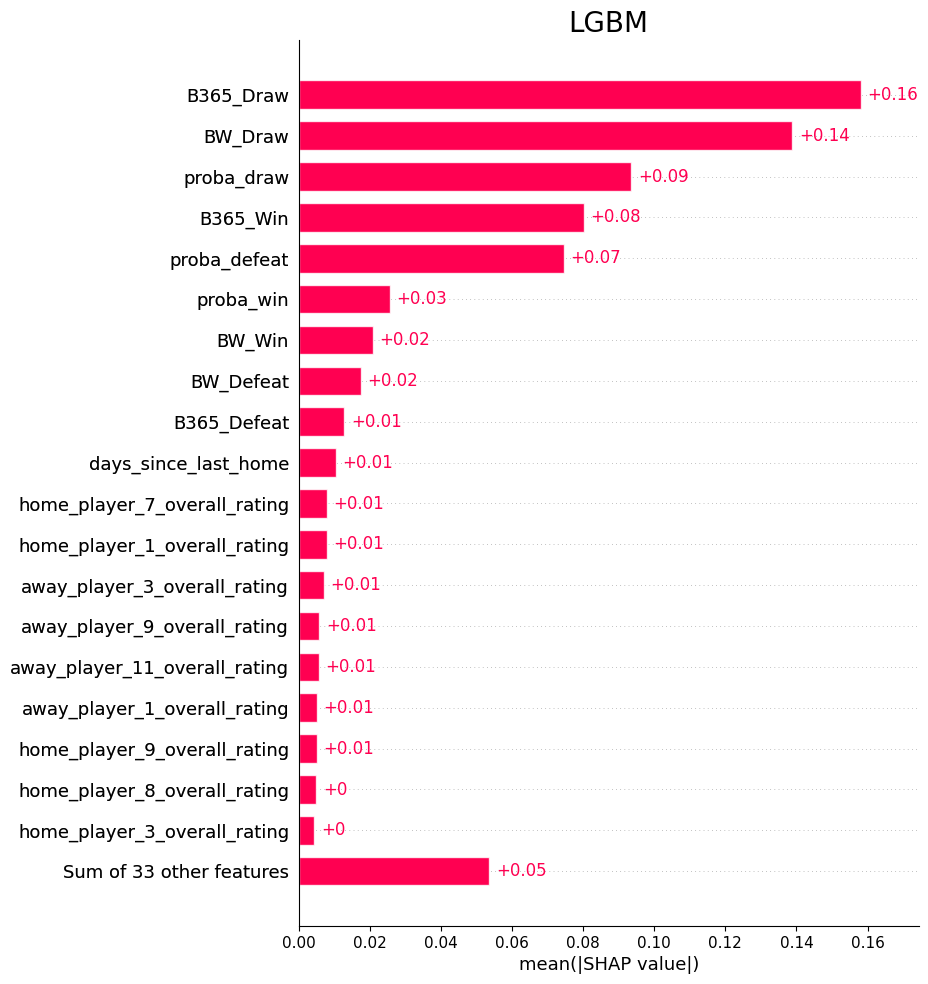

In [111]:
explainer = shap.Explainer(meta_clf_LGBM)
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.bar(shap_values, max_display=20, show=False)
ax = plt.gca()
ax.set_title("LGBM", fontsize=20)
plt.show()

## find best Params for XGBoost Model

In [112]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import pandas as pd

'''
# --- Parameter-Suchraum für XGBClassifier ---
param_dist = {
    'n_estimators': randint(100, 1000),      # Anzahl Bäume
    'learning_rate': uniform(0.01, 0.3),    # Lernrate
    'max_depth': randint(3, 12),            # Tiefe der Bäume
    'min_child_weight': randint(1, 10),     # Mindestgewicht pro Blatt
    'subsample': uniform(0.5, 0.5),         # Zeilen-Sampling (0.5–1.0)
    'colsample_bytree': uniform(0.5, 0.5),  # Feature-Sampling (0.5–1.0)
    'gamma': uniform(0, 5),                 # Mindestverlustreduktion für Split
    'reg_alpha': uniform(0, 1),             # L1-Regularisierung
    'reg_lambda': uniform(0, 1)             # L2-Regularisierung
}

# --- Basismodell ---
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    
)

# --- RandomizedSearchCV Setup ---
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,             # Anzahl der zufälligen Kombinationen
    scoring='precision',   # z. B. 'precision', 'f1', 'roc_auc'
    cv=5,
    verbose=10,
    random_state=42,
    n_jobs=-1
)

# Best hyperparameters found: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 591, 'reg_alpha': np.float64(0.9385527090157502), 'reg_lambda': np.float64(0.0007787658410143283), 'subsample': np.float64(0.9961057796456088)}
# Best cross-validation precision: 0.6415387723556801

print("Performing hyperparameter search for XGBClassifier...")
random_search_xgb.fit(X_meta_train, y_meta_train)

# Bestes Modell speichern
meta_clf_XGB = random_search_xgb.best_estimator_

print("\nBest hyperparameters found:", random_search_xgb.best_params_)
print("Best cross-validation precision:", random_search_xgb.best_score_)
'''

'\n# --- Parameter-Suchraum für XGBClassifier ---\nparam_dist = {\n    \'n_estimators\': randint(100, 1000),      # Anzahl Bäume\n    \'learning_rate\': uniform(0.01, 0.3),    # Lernrate\n    \'max_depth\': randint(3, 12),            # Tiefe der Bäume\n    \'min_child_weight\': randint(1, 10),     # Mindestgewicht pro Blatt\n    \'subsample\': uniform(0.5, 0.5),         # Zeilen-Sampling (0.5–1.0)\n    \'colsample_bytree\': uniform(0.5, 0.5),  # Feature-Sampling (0.5–1.0)\n    \'gamma\': uniform(0, 5),                 # Mindestverlustreduktion für Split\n    \'reg_alpha\': uniform(0, 1),             # L1-Regularisierung\n    \'reg_lambda\': uniform(0, 1)             # L2-Regularisierung\n}\n\n# --- Basismodell ---\nxgb = XGBClassifier(\n    objective=\'binary:logistic\',\n    eval_metric=\'logloss\',\n    use_label_encoder=False,\n    random_state=42,\n    n_jobs=-1,\n\n)\n\n# --- RandomizedSearchCV Setup ---\nrandom_search_xgb = RandomizedSearchCV(\n    estimator=xgb,\n    param_distr

## Train a XGBoost as Secondary Model

In [113]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Best hyperparameters from search
meta_clf_XGB = XGBClassifier(
    colsample_bytree=0.8005575058716043,
    gamma=3.540362888980227,
    learning_rate=0.016175348288740735,
    max_depth=4,
    min_child_weight=8,
    n_estimators=591,
    reg_alpha=0.9385527090157502,
    reg_lambda=0.0007787658410143283,
    subsample=0.9961057796456088,
    random_state=42,
    tree_method="hist",   # GPU if available
    use_label_encoder=False,
    eval_metric="logloss"     # suppresses warning in newer XGBoost
)

meta_clf_XGB.fit(X_meta_train, y_meta_train)


# Step 3: Meta-Vorhersagen treffen
y_meta_pred = meta_clf_XGB.predict(X_meta_test)
print("Meta model accuracy on predicting if primary model is correct:",
      accuracy_score(y_meta_test, y_meta_pred))

# Step 4: Finale Vorhersage – nur wenn Meta-Modell "vertraut"
final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)  # 0 = keine Wette

# Step 5: Trefferquote unter Meta-genehmigten Tipps
nonzero_indices = np.where(final_prediction != 0)[0]
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

correct_XGB = (preds == true_labels).sum()
total_XGB = len(nonzero_indices)
percentage_correct_XGB = correct_XGB / total_XGB if total_XGB > 0 else 0
print(f"Correct predicts on bets: {percentage_correct_XGB:.4f} ({correct_XGB}/{total_XGB})")

# Step 6: Wettstrategie auswerten
df_bets = X_meta_test.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain_XGB = df_bets["money"].sum()
avg_gain_XGB = df_bets["money"].mean()
num_bets_XGB = len(df_bets)

# Sharpe Ratio berechnen
returns = df_bets["money"].values
mean_return = np.mean(returns) if len(returns) > 0 else 0
std_return = np.std(returns, ddof=1) if len(returns) > 1 else 0
sharpe_ratio_XGB = mean_return / std_return if std_return > 0 else np.nan
sharpe_annualized_XGB = sharpe_ratio_XGB * np.sqrt(num_bets_XGB) if not np.isnan(sharpe_ratio_XGB) else np.nan

print(f"\n💰 Gesamtgewinn: {total_gain_XGB:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain_XGB:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets_XGB}")
print(f"⚖️  Sharpe Ratio: {sharpe_ratio_XGB:.3f}")
print(f"📆 Annualized Sharpe Ratio: {sharpe_annualized_XGB:.3f}")


Meta model accuracy on predicting if primary model is correct: 0.6193310657596371
Correct predicts on bets: 0.6665 (1055/1583)

💰 Gesamtgewinn: -23.98 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.015 EUR
🎲 Anzahl getätigter Wetten: 1583
⚖️  Sharpe Ratio: -0.021
📆 Annualized Sharpe Ratio: -0.833


### SHAP XGBoost

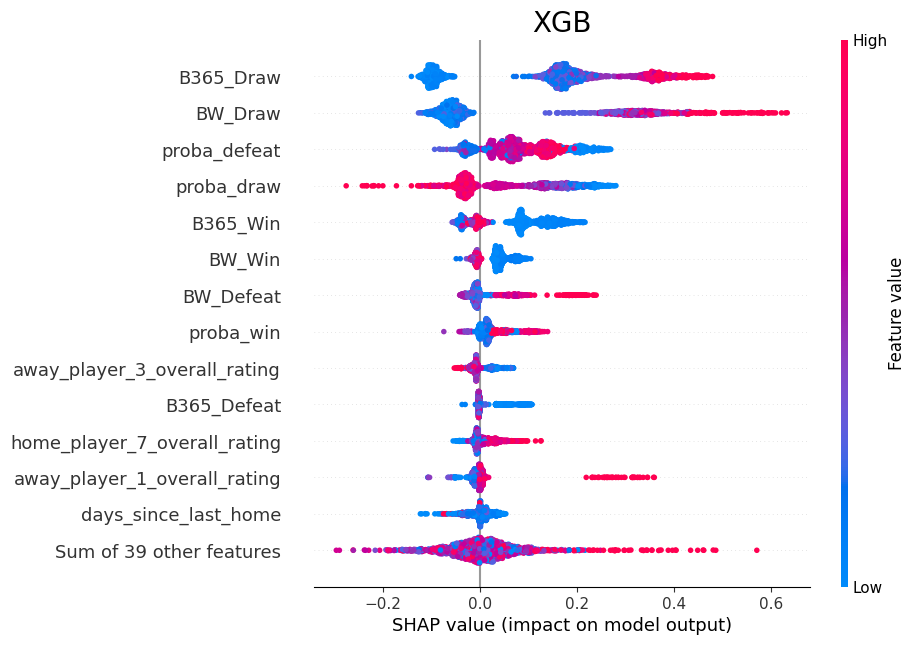

In [114]:

explainer = shap.Explainer(meta_clf_XGB)
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.beeswarm(shap_values, max_display=14, show=False)
ax = plt.gca()
ax.set_title("XGB", fontsize=20)
plt.show()

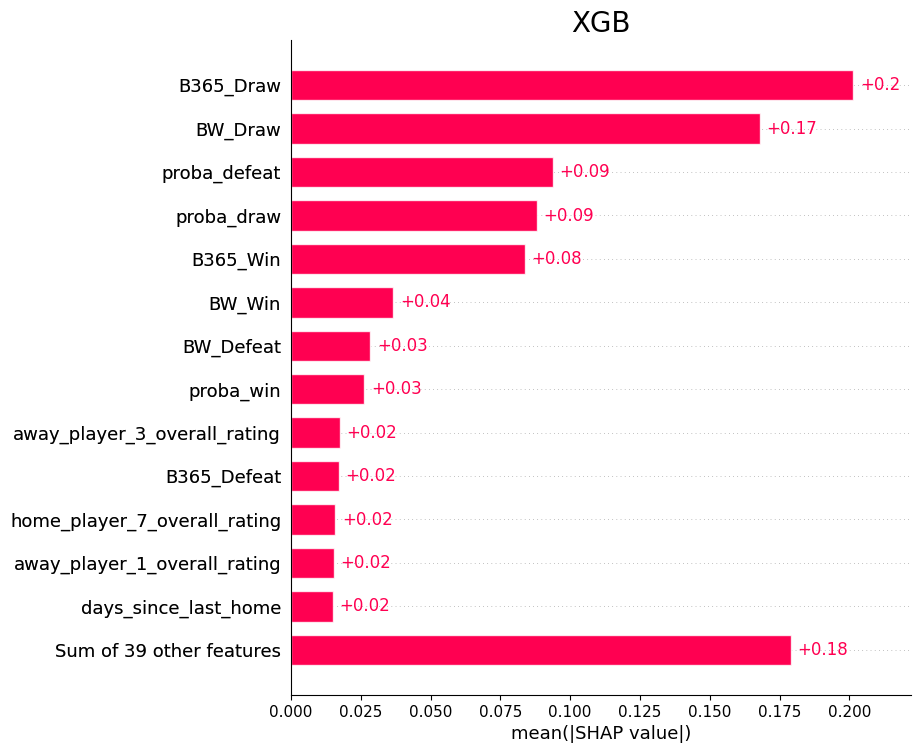

In [115]:
explainer = shap.Explainer(meta_clf_XGB)
shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))
shap.plots.bar(shap_values, max_display=14, show=False)
ax = plt.gca()
ax.set_title("XGB", fontsize=20)
plt.show()

Total Possible Bets in Test Set: 3528


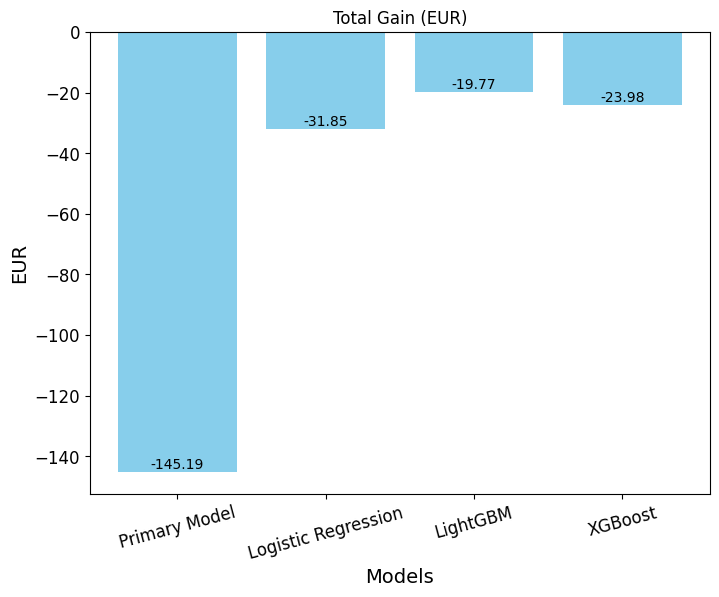

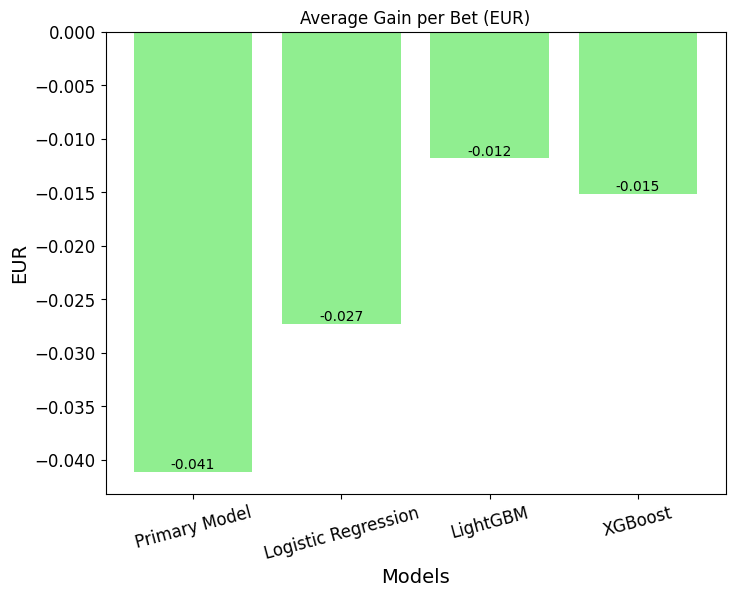

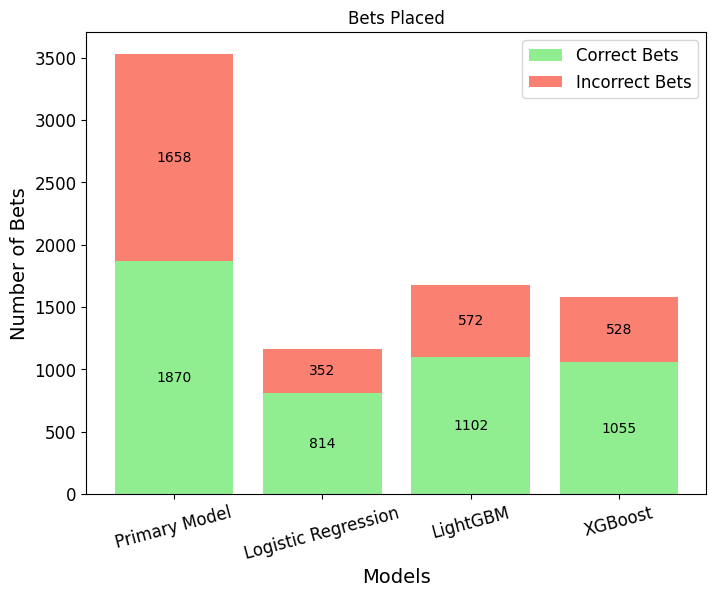

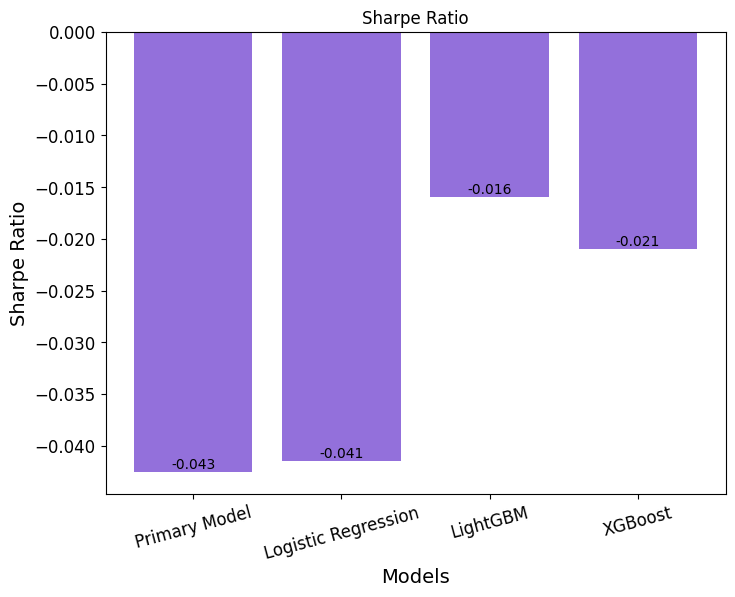

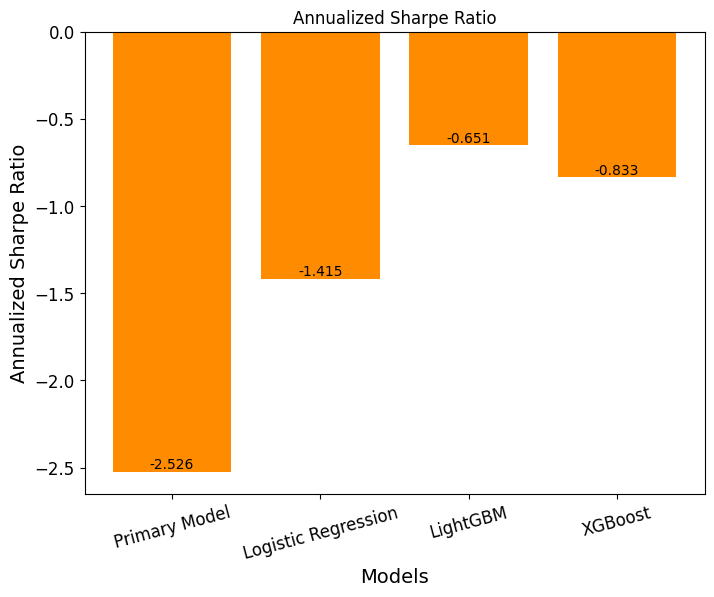

In [116]:
import matplotlib.pyplot as plt

total_possible_bets = len(X_meta_test)  # Total number of matches in the test set
print("Total Possible Bets in Test Set:", total_possible_bets)

# Collect results
models = ["Primary Model", "Logistic Regression", "LightGBM", "XGBoost"]
total_gains = [total_gain_Primary, total_gain_LR, total_gain_LGBM, total_gain_XGB]
avg_gains = [avg_gain_Primary, avg_gain_LR, avg_gain_LGBM, avg_gain_XGB]
num_bets_pct = [
    num_bets_Primary / total_possible_bets * 100,
    num_bets_LR / total_possible_bets * 100,
    num_bets_LGBM / total_possible_bets * 100,
    num_bets_XGB / total_possible_bets * 100
]
correct = [correct_Primary, correct_LR, correct_LGBM, correct_XGB]
incorrect = [nb - c for nb, c in zip([num_bets_Primary, num_bets_LR, num_bets_LGBM, num_bets_XGB], correct)]
sharpe_ratios = [sharpe_ratio_Primary, sharpe_ratio_LR, sharpe_ratio_LGBM, sharpe_ratio_XGB]
sharpe_annualized = [sharpe_annualized_Primary, sharpe_annualized_LR,
                     sharpe_annualized_LGBM, sharpe_annualized_XGB]

# Common font sizes
title_fs = 12
label_fs = 14
tick_fs = 12
bar_value_fs = 10

# -----------------------------
# Plot 1: Total Gain
plt.figure(figsize=(8, 6))
bars = plt.bar(models, total_gains, color="skyblue")
plt.title("Total Gain (EUR)", fontsize=title_fs)
plt.ylabel("EUR", fontsize=label_fs)
plt.xlabel("Models", fontsize=label_fs)
plt.xticks(rotation=15, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontsize=bar_value_fs)
plt.show()

# -----------------------------
# Plot 2: Average Gain per Bet
plt.figure(figsize=(8, 6))
bars = plt.bar(models, avg_gains, color="lightgreen")
plt.title("Average Gain per Bet (EUR)", fontsize=title_fs)
plt.ylabel("EUR", fontsize=label_fs)
plt.xlabel("Models", fontsize=label_fs)
plt.xticks(rotation=15, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{bar.get_height():.3f}",
             ha='center', va='bottom', fontsize=bar_value_fs)
plt.show()

# -----------------------------
# Plot 3: Bets Placed (Correct vs Incorrect)
plt.figure(figsize=(8, 6))
bars_correct = plt.bar(models, correct, color='lightgreen', label='Correct Bets')
bars_incorrect = plt.bar(models, incorrect, bottom=correct, color='salmon', label='Incorrect Bets')

plt.title("Bets Placed", fontsize=title_fs)
plt.ylabel("Number of Bets", fontsize=label_fs)
plt.xlabel("Models", fontsize=label_fs)
plt.xticks(rotation=15, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.legend(fontsize=12)

for bar, c, i in zip(bars_correct, correct, incorrect):
    plt.text(bar.get_x() + bar.get_width()/2, c/2, f"{c}",
             ha='center', va='center', fontsize=bar_value_fs, color='black')
    plt.text(bar.get_x() + bar.get_width()/2, c + i/2, f"{i}",
             ha='center', va='center', fontsize=bar_value_fs, color='black')
plt.show()

# -----------------------------
# Plot 4: Sharpe Ratio
plt.figure(figsize=(8, 6))
bars = plt.bar(models, sharpe_ratios, color="mediumpurple")
plt.title("Sharpe Ratio", fontsize=title_fs)
plt.ylabel("Sharpe Ratio", fontsize=label_fs)
plt.xlabel("Models", fontsize=label_fs)
plt.xticks(rotation=15, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{bar.get_height():.3f}",
             ha="center", va="bottom", fontsize=bar_value_fs)
plt.show()

# -----------------------------
# Plot 5: Annualized Sharpe Ratio
plt.figure(figsize=(8, 6))
bars = plt.bar(models, sharpe_annualized, color="darkorange")
plt.title("Annualized Sharpe Ratio", fontsize=title_fs)
plt.ylabel("Annualized Sharpe Ratio", fontsize=label_fs)
plt.xlabel("Models", fontsize=label_fs)
plt.xticks(rotation=15, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{bar.get_height():.3f}",
             ha="center", va="bottom", fontsize=bar_value_fs)
plt.show()
